# NLP Assignment 1

In [1]:
import os
from collections import Counter
import spacy
import string
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

#torch related packages
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# initial hyperparameters
max_vocab_size=1000
num_epochs = 10 
learning_rate = 0.01
emb_dim = 100
ngram_n = 1
BATCH_SIZE = 32

# 1. Read Data

In [3]:
train_pos_dir = 'aclImdb/train/pos'
train_neg_dir = 'aclImdb/train/neg'
test_pos_dir = 'aclImdb/test/pos'
test_neg_dir = 'aclImdb/test/neg'

def read_file(directory):
    '''
    This function reads all the text files under the directory folder
    and returns the review content and filename in two arrays,
    '''
    all_files = os.listdir(directory)
    text = []
    id_ratings = []
    for file in all_files:
        reviewID, rating = file[:-4].split('_')
        id_ratings.append([reviewID,rating])
        with open(os.path.join(directory,file),'r') as f:
            content = f.read()
        text.append(content)     
    return text,id_ratings

def load_data(pos_dir,neg_dir,data_size):
    '''
    This function reads the negative and positive data and load them into a balanced dataset
    '''
    pos_text, pos_id_ratings = read_file(pos_dir)
    neg_text, neg_id_ratings = read_file(neg_dir)
    text = []
    label = []
    id_ratings = []
    for i in range(int(data_size/2)):
        text.append(pos_text[i])
        label.append(1)
        id_ratings.append(pos_id_ratings)
        text.append(neg_text[i])
        label.append(0)
        id_ratings.append(neg_id_ratings)
    return text,label,id_ratings

In [4]:
# Load the dataset 

# Split into training and validation set
train_split = 20000

train,targets,id_ratings = load_data(train_pos_dir,train_neg_dir,25000)
train_data = train[:train_split]
train_targets = targets[:train_split]
train_id_ratings = id_ratings[:train_split]

val_data = train[train_split:]
val_targets = targets[train_split:]
val_id_ratings = id_ratings[train_split:]

test_data,test_targets,test_id_ratings = load_data(test_pos_dir,test_neg_dir,25000)

In [5]:
# The size of the train, validation and test set
print('Training set size: {}'.format(len(train_data)))
print('Validation set size: {}'.format(len(val_data)))
print('Test set size:{}'.format(len(test_data)))

Training set size: 20000
Validation set size: 5000
Test set size:25000


## 2. Feature Engineering

In [6]:
# The tokenization function 

# import spacy
# import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [110]:
def tokenize_dataset(dataset,n):
    '''
    This function tokenize given dataset into ngrams dataset
    '''
    token_dataset = [] #all the tokens from the samples
    all_tokens = [] #unique tokens
    
    for sample in dataset:
        tokens = tokenize(sample)
        #if it's 1gram
        if(n == 1):
            token_dataset.append(tokens)
            all_tokens += tokens
        #otherwise pair up n tokens to form ngram
        else:
            ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
            token_dataset.append(ngrams)
            all_tokens += ngrams
    
    return token_dataset, all_tokens

In [ ]:
#write tokens to file

# import pickle as pkl
# val set tokens
val_data_tokens, _ = tokenize_dataset(val_data,1)
pkl.dump(val_data_tokens, open("val_data_tokens_1gram.p", "wb"))

In [ ]:
# test set tokens
test_data_tokens, _ = tokenize_dataset(test_data,1)
pkl.dump(test_data_tokens, open("test_data_tokens_1gram.p", "wb"))

In [ ]:
# train set tokens
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,1)
pkl.dump(train_data_tokens, open("train_data_tokens_1gram.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_1gram.p", "wb"))

In [ ]:
def write_tokens_to_file_ngram(val_data,test_data,train_data,n):
    '''
    this function tokenize val,test and train data to ngrams and save them to file
    file name: "val_data_tokens_ngram.p" n={1,2,3,4}
                "test_data_tokens_ngram.p"
                "train_data_tokens_ngram.p"
                "all_train_tokens_ngram.p"
    '''
    # val set tokens
    print ("Tokenizing val data")
    val_data_tokens, _ = tokenize_dataset(val_data,n)
    pkl.dump(val_data_tokens, open("val_data_tokens_"+str(n)+"gram.p", "wb"))

    # test set tokens
    print ("Tokenizing test data")
    test_data_tokens, _ = tokenize_dataset(test_data,n)
    pkl.dump(test_data_tokens, open("test_data_tokens_"+str(n)+"gram.p", "wb"))

    # train set tokens
    print ("Tokenizing train data")
    train_data_tokens, all_train_tokens = tokenize_dataset(train_data,n)
    pkl.dump(train_data_tokens, open("train_data_tokens_"+str(n)+"gram.p", "wb"))
    pkl.dump(all_train_tokens, open("all_train_tokens_"+str(n)+"gram.p", "wb"))

ngram tokenizing

In [ ]:
# 2gram tokenization
write_tokens_to_file_ngram(val_data,test_data,train_data,2)

In [26]:
# 3gram tokenization
write_tokens_to_file_ngram(val_data,test_data,train_data,3)

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [28]:
#4gram tokenization
write_tokens_to_file_ngram(val_data,test_data,train_data,4)

Tokenizing val data
Tokenizing test data
Tokenizing train data


### Load preprocessed token files

In [7]:
def load_ngram_tokens(n):
    '''
    This function load preprocessed train, val and test tokens datasets of ngrams
    @param n: an int from {1,2,3,4}
    '''
    print(str(n)+'gram tokens data:')
    train_data_tokens = pkl.load(open("train_data_tokens_"+str(n)+"gram.p", "rb"))
    all_train_tokens = pkl.load(open("all_train_tokens_"+str(n)+"gram.p", "rb"))

    val_data_tokens = pkl.load(open("val_data_tokens_"+str(n)+"gram.p", "rb"))
    test_data_tokens = pkl.load(open("test_data_tokens_"+str(n)+"gram.p", "rb"))
    
    # double checking
    print ("Train dataset size is {}".format(len(train_data_tokens)))
    print ("Val dataset size is {}".format(len(val_data_tokens)))
    print ("Test dataset size is {}".format(len(test_data_tokens)))
    print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))
    
    return train_data_tokens,all_train_tokens,val_data_tokens,test_data_tokens

In [8]:
#create the vocabulary of most common k tokens
from collections import Counter

# save index 0 for pad and 1 for unk 
PAD_IDX = 0
UNK_IDX = 1

def build_vacob(all_tokens, topk):
    '''
    This function creates the vocabulary of most common k tokens
    and builds token2id, id2token lists
    @param all_tokens: all the unique tokens
    @param max_vocab_size: an int of number of most common tokens needed
    '''
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    
    # add pad and unk to the all tokens list
    id2token = ['<pad>', '<unk>'] + id2token 
    
    #set index for pad and unk
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    
#     print('id2token len: {}'.format(len(id2token)))
    
    return token2id, id2token   

def token2index_dataset(tokens_data,token2id, id2token):
    '''
    This function converts tokenized data samples to id
    @param tokens_data: list of unique tokens
    @param token2id: list of token ids
    @param id2token: list of ordered tokens
    '''
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

def process_token_dataset(n,max_vocab_size):
    '''
    This function processes token dataset to indices dataset
    @param n: an int in {1,2,3,4} ngram
    @param max_vocab_size: an int of maximum vocabulary size
    '''
    #load the tokens dataset
    train_data_tokens,all_train_tokens,val_data_tokens,test_data_tokens = load_ngram_tokens(n)
    
    #build the vocabulary of most common k tokens 
    token2id, id2token = build_vacob(all_train_tokens,max_vocab_size)
    
    # convert token to id for train,val and test dataset
    train_data_indices = token2index_dataset(train_data_tokens,token2id, id2token)
    val_data_indices = token2index_dataset(val_data_tokens,token2id, id2token)
    test_data_indices = token2index_dataset(test_data_tokens,token2id, id2token)
    
#     # double checking
#     print ("Train dataset size is {}".format(len(train_data_indices)))
#     print ("Val dataset size is {}".format(len(val_data_indices)))
#     print ("Test dataset size is {}".format(len(test_data_indices)))
    
    return train_data_indices, val_data_indices, test_data_indices

# 3. Construct Pytorch Input

In [12]:
MAX_SENTENCE_LENGTH = 200

# import numpy as np
# import torch
# from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of imdb tokens 
        @param target_list: list of imdb targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
        
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# Create pytorch dataloader
def IMDBDataloader(train_data_indices, val_data_indices, test_data_indices):
    train_dataset = IMDBDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDBDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = IMDBDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    return train_loader, val_loader, test_loader

# 4. Build Model

In [13]:
# # First import torch related libraries
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [18]:
#processes token dataset to indices dataset
train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
#load token indices to fit pytorch input
train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)


1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527


In [22]:
#initialize model
model = BagOfWords(max_vocab_size+2, emb_dim)

# 5. Define loss function and optimizer

In [23]:
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 5. Train and test model

In [24]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        
        #get the index of the max
        predicted = outputs.max(1, keepdim=True)[1]
     
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        
    return (100 * correct / total)

def early_stop(val_acc_history, t=2, required_progress=0.01):
    if len(val_acc_history) > t:
        if val_acc_history[-1] - val_acc_history[-1-t] <= required_progress:
            return True
    return False

# Training the model
val_acc_history = []
train_acc_history = []
train_loss_history = []

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        
        # report performance
        if (i+1) % (BATCH_SIZE*4) == 0:
            train_acc = test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            val_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
            train_loss_history.append(loss.item())
            
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                   epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))
            
#             # check if we need early stopping
#             stop = early_stop(val_acc_history)
#             if stop:
#                 print("early stop triggered")
#                 break

#     if stop:
#         break

Epoch: [1/10], Step: [128/625], Loss: 0.6029595136642456, Validation Acc:73.36
Epoch: [1/10], Step: [256/625], Loss: 0.45438313484191895, Validation Acc:80.7
Epoch: [1/10], Step: [384/625], Loss: 0.40095508098602295, Validation Acc:81.3
Epoch: [1/10], Step: [512/625], Loss: 0.39209234714508057, Validation Acc:82.56
Epoch: [2/10], Step: [128/625], Loss: 0.3737766146659851, Validation Acc:83.14
Epoch: [2/10], Step: [256/625], Loss: 0.2740996479988098, Validation Acc:83.36
Epoch: [2/10], Step: [384/625], Loss: 0.291684627532959, Validation Acc:80.62
Epoch: [2/10], Step: [512/625], Loss: 0.3601437211036682, Validation Acc:83.22
Epoch: [3/10], Step: [128/625], Loss: 0.5429695248603821, Validation Acc:83.36
Epoch: [3/10], Step: [256/625], Loss: 0.40460580587387085, Validation Acc:82.56
Epoch: [3/10], Step: [384/625], Loss: 0.5192800760269165, Validation Acc:82.82
Epoch: [3/10], Step: [512/625], Loss: 0.39592063426971436, Validation Acc:83.44
Epoch: [4/10], Step: [128/625], Loss: 0.3797815740

In [25]:
print ("Val Acc {}".format(test_model(val_loader, model)))

Val Acc 83.42


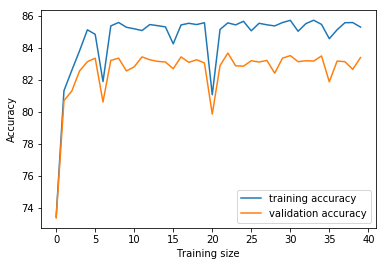

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_acc_history,label = 'training accuracy')
plt.plot(val_acc_history,label = 'validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training size')
plt.legend()
plt.savefig('train_val_acc_10epoch.png')

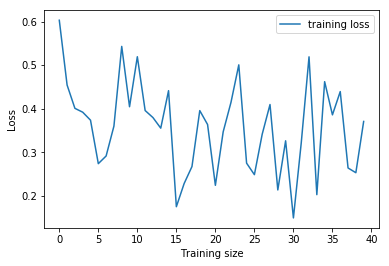

In [27]:
import matplotlib.pyplot as plt
plt.plot( train_loss_history,label = 'training loss')
plt.xlabel('Training size')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_val_loss_10epoch.png')

Seen from the graph, to prevent overfitting, we set num_epochs to be 6

# 6. Parameter Tunning

### 1). N grams

1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527
Epoch: [1/6], Step: [128/625], Loss: 0.5054467916488647, Validation Acc:74.98
Epoch: [1/6], Step: [256/625], Loss: 0.5069160461425781, Validation Acc:80.6
Epoch: [1/6], Step: [384/625], Loss: 0.36976248025894165, Validation Acc:81.94
Epoch: [1/6], Step: [512/625], Loss: 0.2788888216018677, Validation Acc:82.64
Epoch: [2/6], Step: [128/625], Loss: 0.28222596645355225, Validation Acc:82.74
Epoch: [2/6], Step: [256/625], Loss: 0.33014559745788574, Validation Acc:82.64
Epoch: [2/6], Step: [384/625], Loss: 0.28391581773757935, Validation Acc:83.24
Epoch: [2/6], Step: [512/625], Loss: 0.38108015060424805, Validation Acc:83.28
Epoch: [3/6], Step: [128/625], Loss: 0.3927600383758545, Validation Acc:82.98
Epoch: [3/6], Step: [256/625], Loss: 0.20573891699314117, Validation Acc:82.92
Epoch: [3/6], Step: [384/625], Loss: 0.33640074729919434, Validat

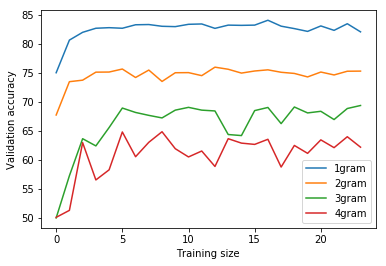

In [35]:
# hyperparameters that remain unchanged
max_vocab_size=1000 
num_epochs = 6
learning_rate = 0.01
emb_dim = 100
BATCH_SIZE = 32

#changed parameters
# ngrams_n

ngram_results = []
for n in range(4): 
    ngram_n = n+1
    #processes token dataset to indices dataset
    train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
    #load token indices to fit pytorch input
    train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)
    #initialize model
    model = BagOfWords(max_vocab_size+2, emb_dim)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    val_acc_history = []

    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            # report performance
            if (i+1) % (BATCH_SIZE*4) == 0:
                
                val_acc = test_model(val_loader, model)
                val_acc_history.append(val_acc)
                
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))

    ngram_results.append(val_acc_history)
    
for i in range(4):
    plt.plot(ngram_results[i],label= str(i+1)+'gram')
    plt.ylabel('Validation accuracy')
    plt.xlabel('Training size')
    plt.legend()
    plt.savefig('val_acc_ngram.png')

Seen from the graph above, the validation accuracy of 1gram tokens are best. Thus we choose 1gram in the following tunning process.

### 2) Vocabulary size

In [47]:
# unchanged hyperparameters
learning_rate = 0.01
emb_dim = 100
BATCH_SIZE = 32
ngram_n = 1
num_epochs = 6

#changed hyperparameters
max_vocab_size_lst=[500,1000, 5000, 10000]

#result_list
vocab_size_results = []

# Training the model

val_acc_history = []
# train_acc_history = []
# train_loss_history = []

for max_vocab_size in max_vocab_size_lst:
    print('max vocab size: {}'.format(max_vocab_size))
    #processes token dataset to indices dataset
    train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
    #load token indices to fit pytorch input
    train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)
    #initialize model
    model = BagOfWords(max_vocab_size+2, emb_dim)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    val_acc_history = []

    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            # report performance
            if (i+1) % (BATCH_SIZE*4) == 0:
                
                val_acc = test_model(val_loader, model)
                val_acc_history.append(val_acc)
                
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))

    vocab_size_results.append(val_acc_history)

max vocab size: 500
1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527
Epoch: [1/6], Step: [128/625], Loss: 0.5742093324661255, Validation Acc:71.5
Epoch: [1/6], Step: [256/625], Loss: 0.35385191440582275, Validation Acc:78.52
Epoch: [1/6], Step: [384/625], Loss: 0.2912500500679016, Validation Acc:78.66
Epoch: [1/6], Step: [512/625], Loss: 0.3923952579498291, Validation Acc:78.96
Epoch: [2/6], Step: [128/625], Loss: 0.4246986508369446, Validation Acc:78.9
Epoch: [2/6], Step: [256/625], Loss: 0.3231949806213379, Validation Acc:78.58
Epoch: [2/6], Step: [384/625], Loss: 0.4381004571914673, Validation Acc:80.5
Epoch: [2/6], Step: [512/625], Loss: 0.5469708442687988, Validation Acc:78.14
Epoch: [3/6], Step: [128/625], Loss: 0.4802470803260803, Validation Acc:80.08
Epoch: [3/6], Step: [256/625], Loss: 0.39400506019592285, Validation Acc:80.14
Epoch: [3/6], Step: [384/625], Loss: 0.361796438694

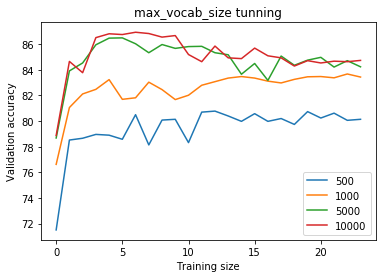

In [49]:
for i in range(len(max_vocab_size_lst)):
    plt.plot(vocab_size_results[i],label= str(max_vocab_size_lst[i]))
    plt.ylabel('Validation accuracy')
    plt.xlabel('Training size')
    plt.title('max_vocab_size tunning')
    plt.legend()
    plt.savefig('val_acc_max_vocab_size.png')

 Choose max_vocab_size = 10000

### 3) Embedding size

1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527
Epoch: [1/6], Step: [128/625], Loss: 0.5877441167831421, Validation Acc:75.88
Epoch: [1/6], Step: [256/625], Loss: 0.4939686059951782, Validation Acc:83.26
Epoch: [1/6], Step: [384/625], Loss: 0.5403681993484497, Validation Acc:85.02
Epoch: [1/6], Step: [512/625], Loss: 0.3066418170928955, Validation Acc:85.8
Epoch: [2/6], Step: [128/625], Loss: 0.16994372010231018, Validation Acc:86.42
Epoch: [2/6], Step: [256/625], Loss: 0.18622805178165436, Validation Acc:86.18
Epoch: [2/6], Step: [384/625], Loss: 0.25709983706474304, Validation Acc:86.78
Epoch: [2/6], Step: [512/625], Loss: 0.13586629927158356, Validation Acc:87.2
Epoch: [3/6], Step: [128/625], Loss: 0.24920554459095, Validation Acc:86.66
Epoch: [3/6], Step: [256/625], Loss: 0.06791529804468155, Validation Acc:86.56
Epoch: [3/6], Step: [384/625], Loss: 0.12196056544780731, Validation 

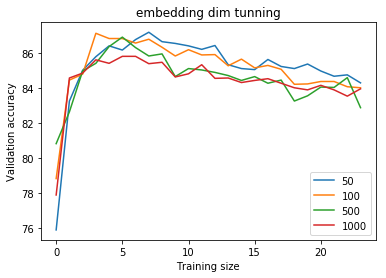

In [50]:
# unchanged hyperparameters
learning_rate = 0.01
BATCH_SIZE = 32
ngram_n = 1
num_epochs = 6
max_vocab_size = 10000 

#changed hyperparameters
emb_dim_lst = [50,100,500,1000]

#result_list
emb_dim_results = []

# Training the model

val_acc_history = []

for emb_dim in emb_dim_lst:
    
    #processes token dataset to indices dataset
    train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
    #load token indices to fit pytorch input
    train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)
    #initialize model
    model = BagOfWords(max_vocab_size+2, emb_dim)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    val_acc_history = []

    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            # report performance
            if (i+1) % (BATCH_SIZE*4) == 0:
                
                val_acc = test_model(val_loader, model)
                val_acc_history.append(val_acc)
                
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))

    emb_dim_results.append(val_acc_history)
    print ("Val Acc {}".format(test_model(val_loader, model)))

for i in range(len(emb_dim_lst)):
    plt.plot(emb_dim_results[i],label= str(emb_dim_lst[i]))
    plt.ylabel('Validation accuracy')
    plt.xlabel('Training size')
    plt.title('embedding dim tunning')
    plt.legend()
    plt.savefig('val_acc_emb_dim.png')

choose 100 as embedding dimensions

### 4) Optimizer

In [62]:
# unchanged hyperparameters
learning_rate = 0.01
BATCH_SIZE = 32
ngram_n = 1
num_epochs = 6
max_vocab_size = 10000 
emb_dim = 100


#result_list
optimizer_acc_results = []
optimizer_loss_results = []

    
#processes token dataset to indices dataset
train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
#load token indices to fit pytorch input
train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)

    
for i in range(2):
    #initialize model
    model = BagOfWords(max_vocab_size+2, emb_dim)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    
    if(i == 0):
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Training the model
    val_acc_history = []
    train_loss_history = []
    
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            # report performance
            if (i+1) % (BATCH_SIZE*4) == 0:

                val_acc = test_model(val_loader, model)
                val_acc_history.append(val_acc)
                train_loss_history.append(loss.item())

                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))

    optimizer_acc_results.append(val_acc_history)
    optimizer_loss_results.append(train_loss_history)
    
    print ("Val Acc {}".format(test_model(val_loader, model)))

1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527
Epoch: [1/6], Step: [128/625], Loss: 0.43917036056518555, Validation Acc:80.34
Epoch: [1/6], Step: [256/625], Loss: 0.4164101183414459, Validation Acc:85.14
Epoch: [1/6], Step: [384/625], Loss: 0.21140821278095245, Validation Acc:86.16
Epoch: [1/6], Step: [512/625], Loss: 0.2097274214029312, Validation Acc:86.44
Epoch: [2/6], Step: [128/625], Loss: 0.19067879021167755, Validation Acc:86.82
Epoch: [2/6], Step: [256/625], Loss: 0.3193698525428772, Validation Acc:86.92
Epoch: [2/6], Step: [384/625], Loss: 0.1889200061559677, Validation Acc:86.46
Epoch: [2/6], Step: [512/625], Loss: 0.11998192965984344, Validation Acc:86.34
Epoch: [3/6], Step: [128/625], Loss: 0.11187190562486649, Validation Acc:86.64
Epoch: [3/6], Step: [256/625], Loss: 0.07728447020053864, Validation Acc:85.16
Epoch: [3/6], Step: [384/625], Loss: 0.1978924423456192, Validat

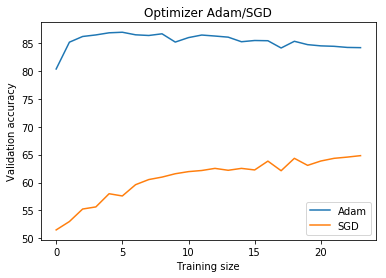

In [63]:
label_lst=['Adam','SGD']
for i in range(2):
    plt.plot(optimizer_acc_results[i],label= label_lst[i])
plt.ylabel('Validation accuracy')
plt.xlabel('Training size')
plt.title('Optimizer Adam/SGD')
plt.legend()
plt.savefig('val_acc_optimizer.png')

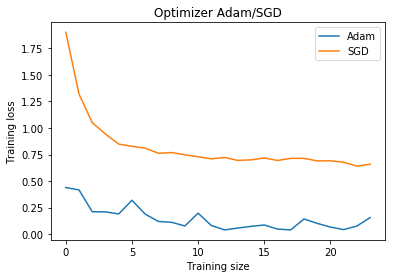

In [64]:
for i in range(2):
    plt.plot(optimizer_loss_results[i],label= label_lst[i])
plt.ylabel('Training loss')
plt.xlabel('Training size')
plt.title('Optimizer Adam/SGD')
plt.legend()
plt.savefig('train_loss_optimizer.png')

### 5) Learning rate

a) static learning rate [0.0001, 0.001, 0.01, 0.1]

In [65]:
# unchanged hyperparameters
BATCH_SIZE = 32
ngram_n = 1
num_epochs = 6
max_vocab_size = 10000 
emb_dim = 100

#changing hyperparameter
learning_rate_lst = [0.0001, 0.001, 0.01, 0.1]

#results list
lr_acc_results = []
lr_loss_results = []

#processes token dataset to indices dataset
train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
#load token indices to fit pytorch input
train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)

for learning_rate in learning_rate_lst:
    print('learning rate ={}'.format(learning_rate))
    #initialize model
    model = BagOfWords(max_vocab_size+2, emb_dim)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training the model
    val_acc_history = []
    train_loss_history = []
    
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            # report performance
            if (i+1) % (BATCH_SIZE*4) == 0:

                val_acc = test_model(val_loader, model)
                val_acc_history.append(val_acc)
                train_loss_history.append(loss.item())

                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))

    lr_acc_results.append(val_acc_history)
    lr_loss_results.append(train_loss_history)
    
    print ("Val Acc {}".format(test_model(val_loader, model)))

1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527
learning rate =0.0001
Epoch: [1/6], Step: [128/625], Loss: 2.7743122577667236, Validation Acc:48.06
Epoch: [1/6], Step: [256/625], Loss: 2.490434408187866, Validation Acc:49.4
Epoch: [1/6], Step: [384/625], Loss: 2.252640962600708, Validation Acc:50.34
Epoch: [1/6], Step: [512/625], Loss: 1.9570882320404053, Validation Acc:50.72
Epoch: [2/6], Step: [128/625], Loss: 1.399893879890442, Validation Acc:51.42
Epoch: [2/6], Step: [256/625], Loss: 1.1830980777740479, Validation Acc:51.78
Epoch: [2/6], Step: [384/625], Loss: 1.046135663986206, Validation Acc:52.18
Epoch: [2/6], Step: [512/625], Loss: 0.945493221282959, Validation Acc:52.66
Epoch: [3/6], Step: [128/625], Loss: 0.8258750438690186, Validation Acc:56.18
Epoch: [3/6], Step: [256/625], Loss: 0.7957881093025208, Validation Acc:56.8
Epoch: [3/6], Step: [384/625], Loss: 0.7756350636482239

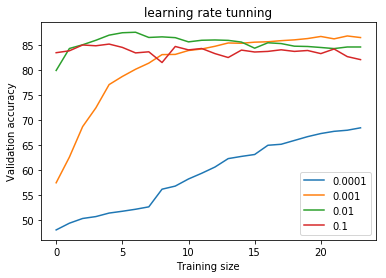

In [67]:
for i in range(len(learning_rate_lst)):
    plt.plot(lr_acc_results[i],label = str(learning_rate_lst[i]))
plt.ylabel('Validation accuracy')
plt.xlabel('Training size')
plt.title('learning rate tunning')
plt.legend()
plt.savefig('val_acc_lr.png')

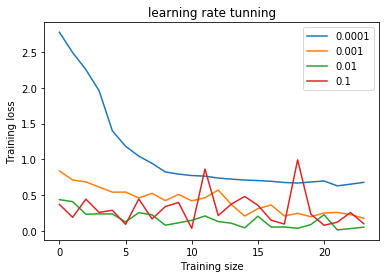

In [68]:
for i in range(len(learning_rate_lst)):
    plt.plot(lr_loss_results[i],label = str(learning_rate_lst[i]))
plt.ylabel('Training loss')
plt.xlabel('Training size')
plt.title('learning rate tunning')
plt.legend()
plt.savefig('train_loss_lr.png')

Choose learning_rate = 0.01

b) linear annealing of learning rate

In [132]:
# unchanged hyperparameters
BATCH_SIZE = 32
ngram_n = 1
num_epochs = 6
max_vocab_size = 10000 
emb_dim = 100

#changing hyperparameter
learning_rate = 0.01

#results list
lr_acc_results = []
lr_loss_results = []

#processes token dataset to indices dataset
train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
#load token indices to fit pytorch input
train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)

for n in range(3):

    #initialize model
    model = BagOfWords(max_vocab_size+2, emb_dim)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training the model
    val_acc_history = []
    train_loss_history = []
    
    learning_rate = 0.01
    for epoch in range(num_epochs):
        print('learning rate = {}'.format(learning_rate))
                
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()

            # report performance
            if (i+1) % (BATCH_SIZE*4) == 0:

                val_acc = test_model(val_loader, model)
                val_acc_history.append(val_acc)
                train_loss_history.append(loss.item())

                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))
        if(n == 1): 
            learning_rate = 0.01 - (epoch+1)*0.001
            for g in optimizer.param_groups:
                g['lr'] = learning_rate

        if(n == 2): 
            learning_rate /= 2
            for g in optimizer.param_groups:
                g['lr'] = learning_rate
            
    lr_acc_results.append(val_acc_history)
    lr_loss_results.append(train_loss_history)
    
    print ("Val Acc {}".format(test_model(val_loader, model)))

1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527
learning rate = 0.01
Epoch: [1/6], Step: [128/625], Loss: 0.49958282709121704, Validation Acc:79.2
Epoch: [1/6], Step: [256/625], Loss: 0.22386766970157623, Validation Acc:83.18
Epoch: [1/6], Step: [384/625], Loss: 0.41396117210388184, Validation Acc:85.8
Epoch: [1/6], Step: [512/625], Loss: 0.4404456913471222, Validation Acc:86.74
learning rate = 0.01
Epoch: [2/6], Step: [128/625], Loss: 0.24821141362190247, Validation Acc:86.96
Epoch: [2/6], Step: [256/625], Loss: 0.3416937589645386, Validation Acc:85.6
Epoch: [2/6], Step: [384/625], Loss: 0.3135157525539398, Validation Acc:86.04
Epoch: [2/6], Step: [512/625], Loss: 0.27714455127716064, Validation Acc:86.96
learning rate = 0.01
Epoch: [3/6], Step: [128/625], Loss: 0.16616247594356537, Validation Acc:86.68
Epoch: [3/6], Step: [256/625], Loss: 0.36718064546585083, Validation Acc:86.06
Epo

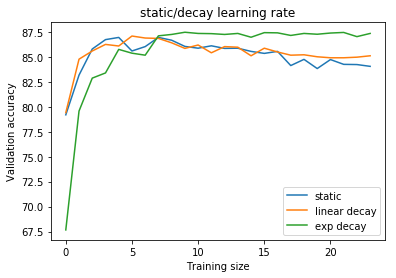

In [133]:
plt.plot(lr_acc_results[0],label = 'static')
plt.plot(lr_acc_results[1],label = 'linear decay')
plt.plot(lr_acc_results[2],label = 'exp decay')
plt.ylabel('Validation accuracy')
plt.xlabel('Training size')
plt.title('static/decay learning rate')
plt.legend()
plt.savefig('val_acc_lr_decay.png')

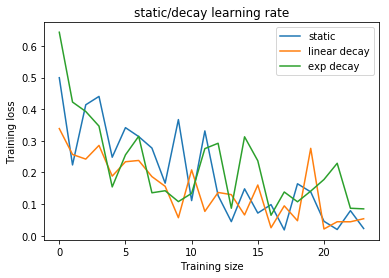

In [134]:
plt.plot(lr_loss_results[0],label = 'static')
plt.plot(lr_loss_results[1],label = 'linear decay')
plt.plot(lr_loss_results[2],label = 'exp decay')
plt.ylabel('Training loss')
plt.xlabel('Training size')
plt.title('static/decay learning rate')
plt.legend()
plt.savefig('train_loss_lr_decay.png')

Choose exp decay learning rate

### 6) Early Stopping

In [123]:
# hyperparameters
BATCH_SIZE = 32
ngram_n = 1
num_epochs = 6
max_vocab_size = 10000 
emb_dim = 100
learning_rate = 0.01

#processes token dataset to indices dataset
train_data_indices, val_data_indices, test_data_indices = process_token_dataset(ngram_n, max_vocab_size)
#load token indices to fit pytorch input
train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)

#initialize model
model = BagOfWords(max_vocab_size+2, emb_dim)
    
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
# Training the model
val_acc_history = []
train_loss_history = []
    
for epoch in range(num_epochs):
#     learning_rate = 0.01 - epoch*0.001
#     for g in optimizer.param_groups:
#         g['lr'] = 0.01 - epoch*0.001
#         print('learning rate={}'.format(g['lr']))

    print('learning rate={}'.format(learning_rate))    
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        # report performance
        if (i+1) % (BATCH_SIZE*4) == 0:

            val_acc = test_model(val_loader, model)
            val_acc_history.append(val_acc)
            train_loss_history.append(loss.item())

            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                    epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))
            
            # check if we need early stopping
            stop = early_stop(val_acc_history)
            if stop:
                print("early stop triggered")
                print('training after {} epochs'.format(epoch+1))
                break
    
    learning_rate /= 2          
    for g in optimizer.param_groups:
        g['lr'] = learning_rate
    
    if stop:
        break

print ("Val Acc {}".format(test_model(val_loader, model)))

1gram tokens data:
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4814527
learning rate=0.01
Epoch: [1/6], Step: [128/625], Loss: 0.47539737820625305, Validation Acc:79.76
Epoch: [1/6], Step: [256/625], Loss: 0.1966523379087448, Validation Acc:82.84
Epoch: [1/6], Step: [384/625], Loss: 0.4796360731124878, Validation Acc:85.8
Epoch: [1/6], Step: [512/625], Loss: 0.2622743844985962, Validation Acc:86.52
learning rate=0.005
Epoch: [2/6], Step: [128/625], Loss: 0.23113055527210236, Validation Acc:87.3
Epoch: [2/6], Step: [256/625], Loss: 0.07788926362991333, Validation Acc:87.12
Epoch: [2/6], Step: [384/625], Loss: 0.4290255308151245, Validation Acc:87.14
early stop triggered
training after 2 epochs
Val Acc 87.14


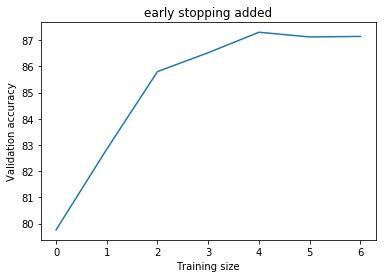

In [124]:
plt.plot(val_acc_history)
plt.ylabel('Validation accuracy')
plt.xlabel('Training size')
plt.title('early stopping added')
plt.savefig('val_acc_earlystop.png')

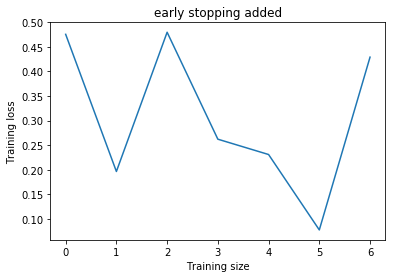

In [125]:
plt.plot(train_loss_history)
plt.ylabel('Training loss')
plt.xlabel('Training size')
plt.title('early stopping added')
plt.savefig('train_loss_earlystop.png')

### 7) Tokenize scheme

additionally remove stop words

In [107]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)&(not token.is_stop)]

In [108]:
print(tokenize("This is an example sentence. We will remove stop words from this"))

['this', 'example', 'sentence', 'we', 'remove', 'stop', 'words']


In [111]:
#tokenize val set
print('tokenizing val set')
val_data_tokens, _ = tokenize_dataset(val_data,1)
pkl.dump(val_data_tokens, open("val_data_tokens_1gram_stopword.p", "wb"))

print('tokenizing test set')
# test set tokens
test_data_tokens, _ = tokenize_dataset(test_data,1)
pkl.dump(test_data_tokens, open("test_data_tokens_1gram_stopword.p", "wb"))

print('tokenizing train set')
# train set tokens
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,1)
pkl.dump(train_data_tokens, open("train_data_tokens_1gram_stopword.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_1gram_stopword.p", "wb"))

tokenizing val set
tokenizing test set
tokenizing train set


In [142]:
#load the preprocessed tokens dataset
train_data_tokens = pkl.load(open("train_data_tokens_1gram_stopword.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_1gram_stopword.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_1gram_stopword.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_1gram_stopword.p", "rb"))

In [143]:
#build the vocabulary of most common k tokens 
token2id, id2token = build_vacob(all_train_tokens,max_vocab_size)
    
# convert token to id for train,val and test dataset
train_data_indices = token2index_dataset(train_data_tokens,token2id, id2token)
val_data_indices = token2index_dataset(val_data_tokens,token2id, id2token)
test_data_indices = token2index_dataset(test_data_tokens,token2id, id2token)

print('train: {} \n val: {} \n test: {}'.format(len(train_data_indices),len(val_data_indices),len(test_data_indices)))

train: 20000 
 val: 5000 
 test: 25000


In [144]:
# tuned hyperparameters
BATCH_SIZE = 32
ngram_n = 1
num_epochs = 6
max_vocab_size = 10000 
emb_dim = 100
learning_rate = 0.01

#load token indices to fit pytorch input
train_loader, val_loader, test_loader = IMDBDataloader(train_data_indices, val_data_indices, test_data_indices)

#initialize model
model = BagOfWords(max_vocab_size+2, emb_dim)
    
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
# Training the model
val_acc_history = []
train_loss_history = []
    
for epoch in range(num_epochs):
    print('learning rate ={}'.format(learning_rate))    
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        # report performance
        if (i+1) % (BATCH_SIZE*4) == 0:

            val_acc = test_model(val_loader, model)
            val_acc_history.append(val_acc)
            train_loss_history.append(loss.item())

            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Acc:{5}'.format( 
                    epoch+1, num_epochs, i+1, len(train_loader), loss.item(),val_acc))
            
            # check if we need early stopping
            stop = early_stop(val_acc_history)
            if stop:
                print("early stop triggered")
                print('training after {} epochs'.format(epoch+1))
                break
                
    learning_rate /= 2          
    for g in optimizer.param_groups:
        g['lr'] = learning_rate
    
    if stop:
        break

print ("Val Acc {}".format(test_model(val_loader, model)))


learning rate =0.01
Epoch: [1/6], Step: [128/625], Loss: 0.41999551653862, Validation Acc:82.02
Epoch: [1/6], Step: [256/625], Loss: 0.46682488918304443, Validation Acc:86.08
Epoch: [1/6], Step: [384/625], Loss: 0.2197265475988388, Validation Acc:86.88
Epoch: [1/6], Step: [512/625], Loss: 0.290327250957489, Validation Acc:87.82
learning rate =0.005
Epoch: [2/6], Step: [128/625], Loss: 0.12067976593971252, Validation Acc:87.76
Epoch: [2/6], Step: [256/625], Loss: 0.20374059677124023, Validation Acc:88.26
Epoch: [2/6], Step: [384/625], Loss: 0.11971070617437363, Validation Acc:87.8
Epoch: [2/6], Step: [512/625], Loss: 0.17605812847614288, Validation Acc:87.7
early stop triggered
training after 2 epochs
Val Acc 87.7


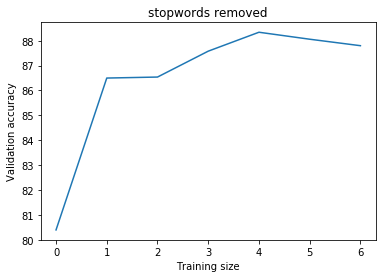

In [139]:
plt.plot(val_acc_history)
plt.ylabel('Validation accuracy')
plt.xlabel('Training size')
plt.title('stopwords removed')
plt.savefig('val_acc_stopword.png')

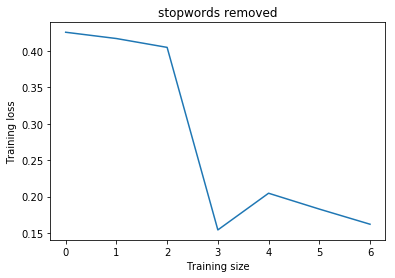

In [140]:
plt.plot(train_loss_history)
plt.ylabel('Training loss')
plt.xlabel('Training size')
plt.title('stopwords removed')
plt.savefig('train_loss_stopword.png')

In [141]:
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

Val Acc 87.8
Test Acc 86.648


### List 3 correct and 3 incorrect predictions on validation set

In [192]:

val_dataset = IMDBDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)

predictions = []
# model.eval()
for data, lengths, labels in val_loader:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)
    
    #get the index of the max
    predicted = outputs.max(1, keepdim=True)[1]
    predictions += predicted.numpy().tolist()

prediction = [item[0] for item in predictions]

correct = 0
incorrect = 0
for i in range(len(val_data)):
    if(val_targets[i] == prediction[i]):
        print('correct prediction{} label:{}'.format(correct+1,val_targets[i]))
        review = val_data[i].replace("<br />","\n")
        print(review+'\n\n')
        correct +=1
    if(correct > 2):break

for i in range(len(val_data)):
    if(val_targets[i] != prediction[i]):
        print('incorrect prediction{} label:{}'.format(incorrect+1,val_targets[i]))
        review = val_data[i].replace("<br />","\n")
        print(review+'\n\n')
        incorrect +=1
    if(incorrect > 2):break

correct prediction1 label:1
There are enough sad stories about women and their oppression by religious, political and societal means. Not to diminish the films and stories about genital mutilation and reproductive rights, as well as wage inequality, and marginalization in society, all in the name of Allah or God or some other ridiculous justification, but sometimes it is helpful to just take another approach and shed some light on the subject.

The setting is the 2006 match between Iran and Bahrain to qualify for the World Cup. Passions are high and several women try to disguise themselves as men to get into the match.

The women who were caught (Played by Sima Mobarak-Shahi, Shayesteh Irani, Ayda Sadeqi, Golnaz Farmani, and Mahnaz Zabihi) and detained for prosecution provided a funny and illuminating glimpse into the customs of this country and, most likely, all Muslim countries. Their interaction with the Iranian soldiers who were guarding and transporting them, both city and village